In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def show_tensor_images(image_tensor, num_images=25, nrow=5, size=(3, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


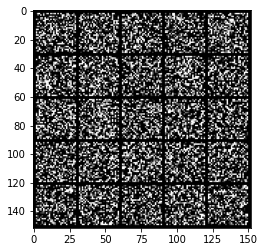

In [ ]:
#checking the show_tensor_images function
tensor = torch.randn((25,28,28))
show_tensor_images(tensor)

In [ ]:
def get_noise(n_samples,z_dim):
  '''
  Function to get random noise vector.
  creates a tensor of shape(batch,Z-dim) filled with random numbers from the normal distribution.
  Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
  ''' 

  return torch.randn(n_samples,z_dim, device=device)

In [ ]:
def get_generator_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)

        ConvTranspose2d---> Generally for upsampling
  '''
  if not final_layer:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
        
    )
  else: 
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh()
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim=10, im_chan=3, hidden_dim=64):
    super().__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim * 8),
        get_generator_block(hidden_dim * 8, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim),
        get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
    )

  def unsqueeze_noise(self, noise):
    '''
    Given a noise tensor,returns a copy of that noise with width and height = 1 and channels = z_dim.
    Parameters:
        noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    return noise.view(len(noise), self.z_dim, 1, 1)
  
  def forward(self, noise):
    
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

In [ ]:
def get_classifier_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
  '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
  '''

  if not final_layer:
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else: 
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride)
    )

In [ ]:
class Classifier(nn.Module):
  def __init__(self,im_chan=3, n_classes = 10, hidden_dim=64):
    super().__init__()
    self.batch_size = batch_size
    self.classifier = nn.Sequential(
        get_classifier_block(im_chan, hidden_dim),
        get_classifier_block(hidden_dim, hidden_dim * 2),
        get_classifier_block(hidden_dim * 2, hidden_dim * 4, stride = 3),
        get_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
    )

  def forward(self,image):
    return self.classifier(image).view(len(image), -1)

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [ ]:
z_dim = 64
batch_size = 32
n_classes = 40

In [ ]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


In [ ]:
feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

In [ ]:
iterations = 10
n_images = 10
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
gen_image_history = []
try:
  feature_index = feature_names.index("Smiling")
except:
  print('Index Not found; Assigning index = 1')
  feature_index = 1

for i in range(iterations):

  opt.zero_grad()
  g_z = gen(noise)
  gen_image_history.append(g_z)
  feature_score = classifier(g_z)[:,feature_index].mean()
  feature_score.backward()
  noise.data = noise + (noise.grad * 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


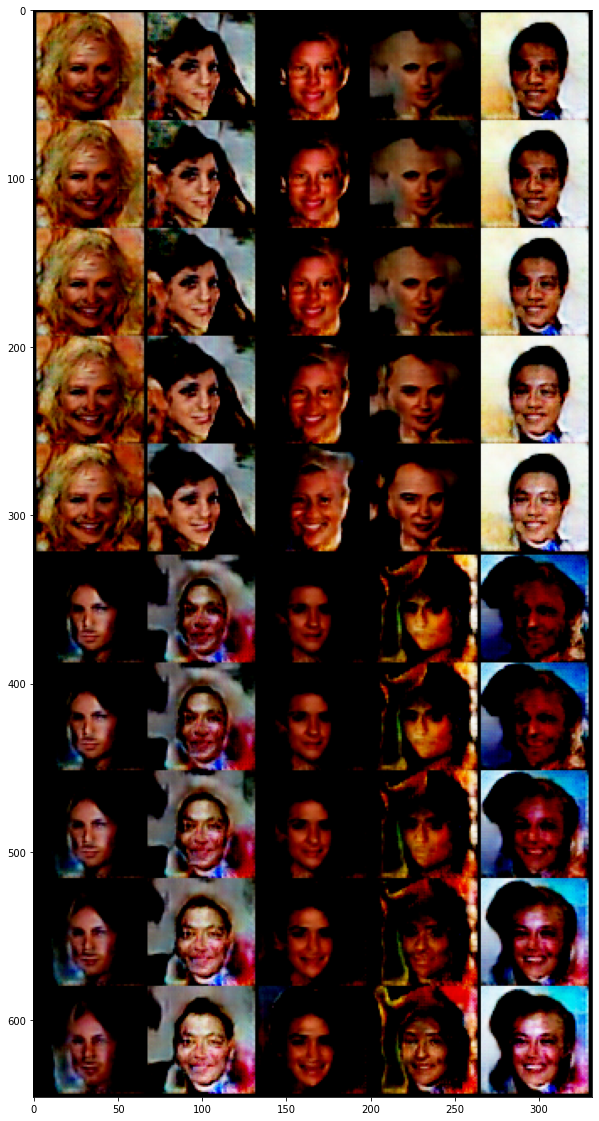

In [ ]:
plt.rcParams['figure.figsize'] = [n_images * 2, 10 * 2]
show_tensor_images(torch.cat(gen_image_history[::2], dim=2), num_images=n_images, nrow=n_images)

Second Approach: Encouraging the Disentanglement


You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

In [79]:
def get_scores(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
  '''
  Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
  
  other_dis = current_classifications[:,other_indices] - original_classifications[:,other_indices]
  other_class_penalty = -torch.norm(other_dis, dim=1).mean() * penalty_weight
  target_score = current_classifications[:,target_indices].mean()
  return target_score + other_class_penalty 

In the following block of code, you will run the gradient ascent with this new score function. You might notice a few things after running it:

It may fail more often at producing the target feature when compared to the original approach. This suggests that the model may not be able to generate an image that has the target feature without changing the other features. This makes sense! For example, it may not be able to generate a face that's smiling but whose mouth is NOT slightly open. This may also expose a limitation of the generator. Alternatively, even if the generator can produce an image with the intended features, it might require many intermediate changes to get there and may get stuck in a local minimum.

This process may change features which the classifier was not trained to recognize since there is no way to penalize them with this method. Whether it's possible to train models to avoid changing unsupervised features is an open question.

In [80]:
iterations = 10
n_images = 10
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
gen_image_history = []
try:
  feature_index = feature_names.index("Smiling")
except:
  print('Index Not found; Assigning index = 1')
  feature_index = 1

original_classifications = classifier(gen(noise)).detach()
other_indices = [cur_idx != feature_index for cur_idx, _ in enumerate(feature_names)]

for i in range(iterations):

  opt.zero_grad()
  g_z = gen(noise)
  gen_image_history.append(g_z)
  feature_score = get_scores(classifier(g_z), original_classifications, feature_index, other_indices,penalty_weight=0.1)
  feature_score.backward()
  noise.data = noise + (noise.grad * 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


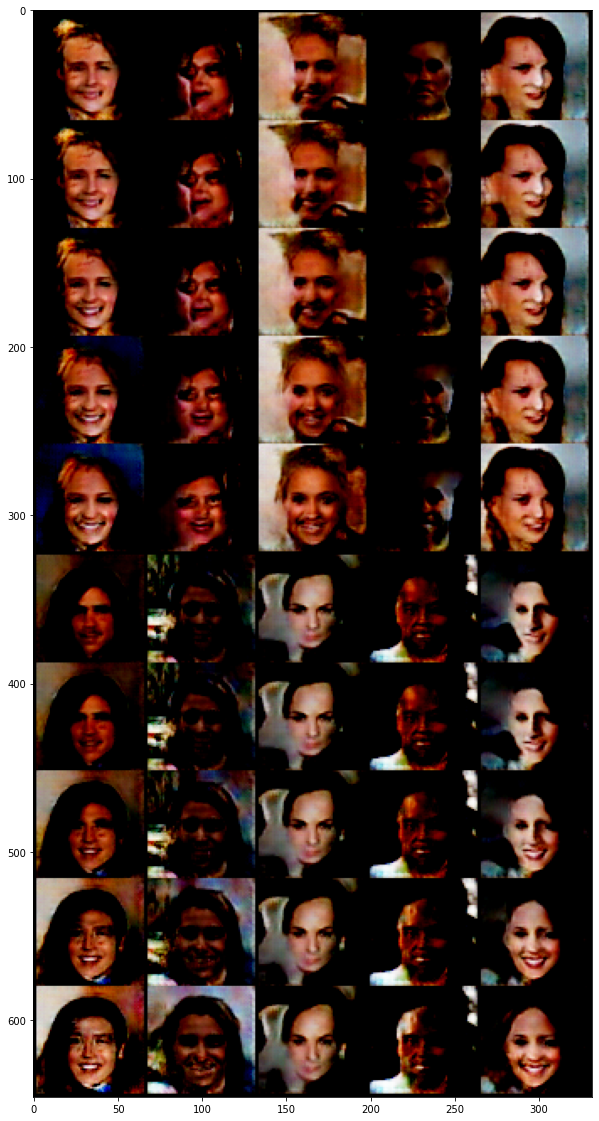

In [81]:
plt.rcParams['figure.figsize'] = [n_images * 2, 10 * 2]
show_tensor_images(torch.cat(gen_image_history[::2], dim=2), num_images=n_images, nrow=n_images)